# Partisan Voter Index for Texas State Legislatures - Analysis

This project aims to produce Partisan Voter Index(PVI) metrics for the upper and lower Texas State Legislatures.

Data pre-processing code, including merging precincts to 2022 legislative districts, can be found in the TX PVI ETL notebook.

# Sections

- <a href="#PS">Reading in Shapefiles</a><br>
- <a href="#ER">Reading in Precinct-level Election returns</a><br>
- <a href="#agg">Aggregating Statewide Race Data</a><br>
- <a href="#baseline">Calculating Baseline Lean</a><br>
- <a href="#pvi">Calculating PVI</a><br>
- <a href="#vpvi">Visualizing PVI</a><br>
- <a href="#ta">Takeaways</a><br>
- <a href="#fw">Future Work</a><br>

<p><a name="PS"></a></p>

## Importing Packages, Reading in Shapefiles

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from fiona.crs import from_epsg
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
#importing helper functions from helper module
from helper_module import *

Texas Enacted new state legislative district boundaries after the 2020 census. Loading in new maps and old maps to compare.

In [3]:
#2022 Texas State Legislative Districts, Upper
new_senate = gpd.read_file('data/raw/maps/tx_sldu_2022/PLANS2168.shp')
new_senate = new_senate.to_crs(epsg=3857)

#2022 Texas State Legislative Districts, Lower
new_house = gpd.read_file('data/raw/maps/tx_sldl_2022/PLANH2316.shp')
new_house = new_house.to_crs(epsg=3857)

#2012-2021 Texas State Legislative Districts, Upper
old_senate = gpd.read_file('data/raw/maps/tx_sldu_2012/tx_sldu_2012_to_2021.shp')
old_senate = old_senate.to_crs(epsg=3857)

#2019-2021 Texas State Legislative Districts, Lower
old_house = gpd.read_file('data/raw/maps/tx_sldl_2019/tx_sldl_2019_to_2021.shp')
old_house = old_house.to_crs(epsg=3857)

Testing to make sure shapefiles loaded correctly.
Texas Senate has 31 seats, Texas House has 150.

In [4]:
#new_senate.head()
#new_senate.shape() #should be 31 rows
#new_senate.info() #checking for data types, and null values

#new_house.head()
#new_house.info() #should be 150 rows
#new_house.info() #checking for data types, and null values

#old_senate.head()
#old_senate.info()

#old_house.head()
#old_house.info()

Standardizing column names for all shapefiles, setting index

In [5]:
for item in [new_senate, new_house, old_senate, old_house]:
    item.columns = ['district', 'geometry']
    #item.set_index('district', inplace = True)

Visualizing new and old state legislative districts side by side

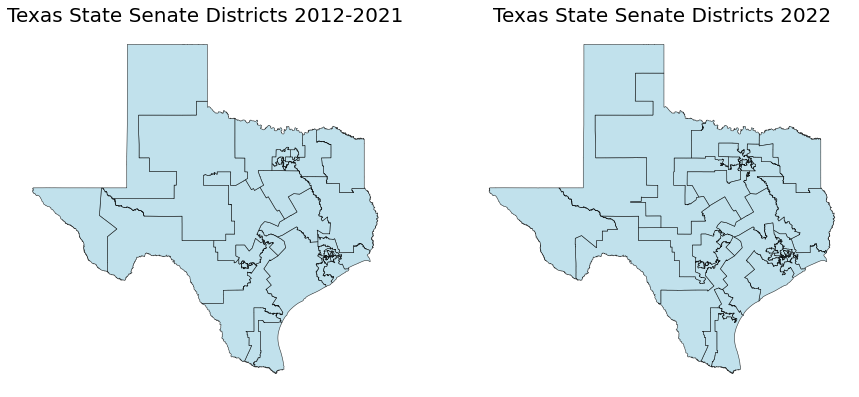

In [6]:
# creating two subplots to visualize Texas State Senate
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs

# old state senate map on the left
old_senate.plot( color = 'lightblue',
            edgecolor='black',
            linewidth=.6, 
            alpha=0.75, 
            ax=ax1, # assigning the map to the subplot
            legend=True
           )

ax1.axis("off")
ax1.set_title("Texas State Senate Districts 2012-2021",
             size = 20)

# new state senate map on the right
new_senate.plot( color ='lightblue',
            edgecolor='black', 
            linewidth=.6, 
            alpha=0.75, 
            ax=ax2, #
            legend=True
           )

ax2.axis("off")
ax2.set_title("Texas State Senate Districts 2022",
             size = 20)

#saving plot in figure folder
plt.savefig('./figures/tx_senate_side_by_side.png')

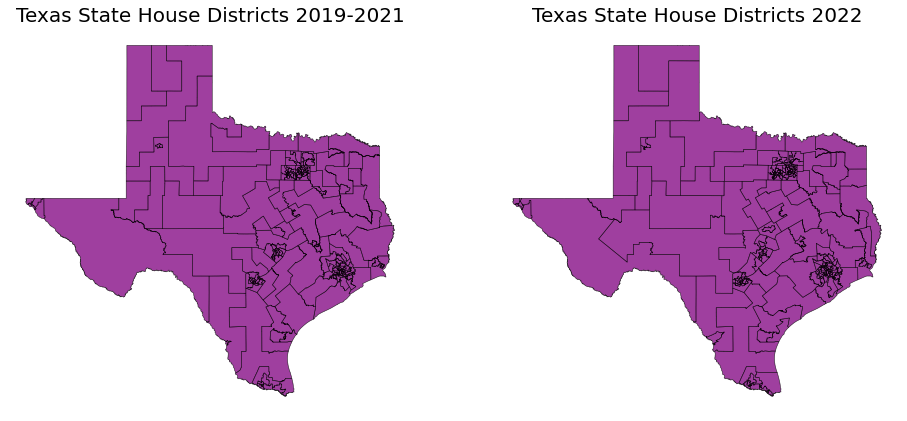

In [7]:
#creating two subplots to visualize Texas State House
fig, axs = plt.subplots(1, 2, figsize=(16, 14))

# name each subplot
ax1, ax2 = axs

# old state house map on the left
old_house.plot( color = 'purple',
            edgecolor='black',
            linewidth=.6, 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Texas State House Districts 2019-2021",
             size = 20)

# new state house map on the right
new_house.plot( color ='purple',
            edgecolor='black', 
            linewidth=.6, 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot
            legend=True
           )

ax2.axis("off")
ax2.set_title("Texas State House Districts 2022",
             size = 20)

#saving plot in figure folder
plt.savefig('./figures/tx_house_side_by_side.png')

<p><a name="ER"></a></p>

## Reading in Precinct-level Election Returns

### Reading 2020, 2018 and 2016 election returns into geopandas.
The data files contains cleaned and formatted precinct-wise vote tallies for state-wide elections by year.

**In 2020, Texans cast votes for:**
* President of the United States
* One Congressional Senator
* State Railroad Commissioner


**In 2018, Texans across the state cast votes for :**
* Congressional Senate Seat
* Governor of Texas
* State Lieutenant Governor
* State Attorney General
* State Comptroller
* State Commissioner of General Land Office
* State Commissioner of Agriculture
* State Railroad Commissioner


**In 2016, Texans across the state cast votes for :**
* President of the United States
* State Railroad Commissioner

Additionally, there were state wide elections for State Supreme Court Justices, and State Criminal Court Justices in 2020 and 2016. Partisan Voter Indexes traditionally use election data from the executive branch of government, so these vote tallies were excluded from the analysis because they pertain to the judicial branch.
    
The data does not include vote tallies for regional representatives (at the federal and state-wide level)

In [8]:
#Reading in cleaned election returns, matched to 2022 legislative districts
ctx_2020 = pd.read_csv('data/cleaned/ctx_2020.csv')
ctx_2018 = pd.read_csv('data/cleaned/ctx_2018.csv')
ctx_2016 = pd.read_csv('data/cleaned/ctx_2016.csv')

In [9]:
#Examining one dataset
ctx_2018.head()

,uss_18_r,uss_18_tot,gov_18_r,gov_18_tot,ltg_18_r,ltg_18_tot,atg_18_r,atg_18_tot,com_18_r,com_18_tot,lan_18_r,lan_18_tot,agr_18_r,agr_18_tot,rrc_18_r,rrc_18_tot,SD,HD
0,106,1030,139,1012,123,1010,114,1012,110,978,119,1006,104,994,107,994,16.0,107.0
1,926,2022,1040,2014,929,2005,892,2001,1011,1981,981,1998,912,1992,1020,1997,17.0,133.0
2,325,356,331,354,319,350,318,349,323,348,319,345,320,351,314,345,3.0,11.0
3,1034,1608,1103,1606,1020,1583,1037,1588,1048,1551,1082,1569,1031,1572,1066,1557,30.0,62.0
4,702,2252,799,2221,736,2217,700,2217,729,2189,745,2208,700,2219,744,2207,7.0,135.0


<p><a name="agg"></a></p>

# Aggregating State Wide Race Data for 2016, 2018, 2020

* Compiling the total vote count for major party candidates for each state wide race, across ~9000 precincts per election year.
* Transforming vote totals into percentages, to be able to compare across years and races.
* Comparing vote totals for federal races vs state-wide races to assess downballot drop-off.

In [10]:
# Initialize a blank dataframe for aggregate percentages of two-party vote share
voteshare = pd.DataFrame(columns = ['year','race','r_vote','total_vote','r_pct'])
#Creating a list of election prefixes
elec_list = ['pre_16', 'rrc_16',
             'uss_18', 'gov_18', 'ltg_18', 'atg_18', 'com_18','lan_18', 'agr_18', 'rrc_18',
             'pre_20','uss_20', 'rrc_20'] 

In [11]:
# Matching elections to the appropriate election return dataset
for i, item in enumerate(elec_list):
    if '16' in item:
        print(item + ' uses 2016 dataset')
        data = ctx_2016
    elif '18' in item:
        print(item + ' uses 2018 datset')
        data = ctx_2018
    else:
        print(item + 'uses 2020 dataset')
        data = ctx_2020
    voteshare.loc[i] = find_pct(data, item) #appending each election to the voteshares dataframe with calculated vote tally

pre_16 uses 2016 dataset
rrc_16 uses 2016 dataset
uss_18 uses 2018 datset
gov_18 uses 2018 datset
ltg_18 uses 2018 datset
atg_18 uses 2018 datset
com_18 uses 2018 datset
lan_18 uses 2018 datset
agr_18 uses 2018 datset
rrc_18 uses 2018 datset
pre_20uses 2020 dataset
uss_20uses 2020 dataset
rrc_20uses 2020 dataset


In [12]:
#checking the df
voteshare
#voteshare.info()

,year,race,r_vote,total_vote,r_pct
0,16,pre,4684573,8561998,54.713549
1,16,rrc,4648585,8010185,58.033429
2,18,uss,4260232,8305503,51.294088
3,18,gov,4655963,8202236,56.764558
4,18,ltg,4260764,8121260,52.464322
5,18,atg,4191029,8089068,51.811024
6,18,com,4376584,7946935,55.072603
7,18,lan,4434957,8002556,55.419256
8,18,agr,4221301,8043087,52.483592
9,18,rrc,4376500,7988287,54.786464


In [13]:
#insert a column for federal races
voteshare['fed'] = np.nan

for index, race in voteshare.iterrows():
    if voteshare.loc[index, ('race')] == 'pre' or voteshare.loc[index, ('race')] == 'uss':
        voteshare.loc[index, ('fed')] = 1
    else:
        voteshare.loc[index, ('fed')] = 0
        
voteshare.head()

,year,race,r_vote,total_vote,r_pct,fed
0,16,pre,4684573,8561998,54.713549,1.0
1,16,rrc,4648585,8010185,58.033429,0.0
2,18,uss,4260232,8305503,51.294088,1.0
3,18,gov,4655963,8202236,56.764558,0.0
4,18,ltg,4260764,8121260,52.464322,0.0


In [14]:
#exporting voteshare dataframe to csv
voteshare.to_csv(r'data/cleaned/voteshare.csv', index = False)

<p><a name="baseline"></a></p>

# Calculating the 'baseline' lean for each year

compressing all vote tallies for in a year into one percentage of baseline 'lean' for
- all races
- federal races
- state wide races

In [15]:
#adding in aggregate of all races per year
df1 = voteshare.groupby('year').agg({'r_vote': 'sum',
                                    'total_vote':'sum',
                                    'race':'count'})
df1['r_pct'] = df1['r_vote']/df1['total_vote']
df1['avg_votes'] = df1['total_vote']/df1['race']
df1.reset_index(inplace = True)
df1

,year,r_vote,total_vote,race,r_pct,avg_votes
0,16,9333158,16572183,2,0.563182,8.286092e+06
1,18,34777330,64698932,8,0.537526,8.087366e+06
2,20,17684282,32623682,3,0.542069,1.087456e+07


In [16]:
#adding in aggregates, split by federal and state races
df2 = voteshare.groupby(['year', 'fed']).agg({'r_vote': 'sum',
                                    'total_vote':'sum',
                                    'race':'count'})
df2['r_pct'] = df2['r_vote']/df2['total_vote']
df2['avg_votes'] = df2['total_vote']/df2['race']
df2.reset_index(inplace = True)
df2

,year,fed,r_vote,total_vote,race,r_pct,avg_votes
0,16,0.0,4648585,8010185,1,0.580334,8.010185e+06
1,16,1.0,4684573,8561998,1,0.547135,8.561998e+06
2,18,0.0,30517098,56393429,7,0.541146,8.056204e+06
3,18,1.0,4260232,8305503,1,0.512941,8.305503e+06
4,20,0.0,5831164,10623329,1,0.548902,1.062333e+07
5,20,1.0,11853118,22000353,2,0.538769,1.100018e+07


In [17]:
#concatenating data frames into one aggregate data frame
vs_agg = pd.concat([df1, df2], axis = 0)
#imputing values for 'fed' column, and renaming columns
vs_agg.reset_index(inplace = True)
vs_agg.rename(columns = {'fed':'r_type', 'index': 'old'}, inplace = True)
vs_agg.iloc[:3, -1] = 2
vs_agg.drop(['old'], 1, inplace= True)

In [18]:
#setting index for ease
new_val = []
for index, r_type in vs_agg.iterrows():
    new = str(vs_agg.loc[index, 'year'])
    if str(vs_agg.loc[index, 'r_type']) == 0:
        new_2 = 'sta'
    new_2 = str(vs_agg.loc[index, 'r_type'])
    new_val.append(new +'_'+ new_2)
vs_agg.index = new_val
#exporting dataframe to csv
vs_agg.to_csv(r'data/cleaned/voteshare_aggregated.csv', index = False)
vs_agg

,year,r_vote,total_vote,race,r_pct,avg_votes,r_type
16_2.0,16,9333158,16572183,2,0.563182,8.286092e+06,2.0
18_2.0,18,34777330,64698932,8,0.537526,8.087366e+06,2.0
20_2.0,20,17684282,32623682,3,0.542069,1.087456e+07,2.0
16_0.0,16,4648585,8010185,1,0.580334,8.010185e+06,0.0
16_1.0,16,4684573,8561998,1,0.547135,8.561998e+06,1.0
18_0.0,18,30517098,56393429,7,0.541146,8.056204e+06,0.0
18_1.0,18,4260232,8305503,1,0.512941,8.305503e+06,1.0
20_0.0,20,5831164,10623329,1,0.548902,1.062333e+07,0.0
20_1.0,20,11853118,22000353,2,0.538769,1.100018e+07,1.0


### Plotting the differences baseline lean in federal elections vs statewide elections

In [19]:
fed = [] #baseline lean for federal
sta = [] #baseline lean for state wide
alr = [] #baseline lean for all races
        
for index, r_type in vs_agg.iterrows():
    if vs_agg.loc[index, 'r_type'] == 2:
            alr.append(vs_agg.loc[index,'r_pct'])
    elif vs_agg.loc[index, 'r_type'] == 1:
            fed.append(vs_agg.loc[index,'r_pct'])
    elif vs_agg.loc[index, 'r_type'] == 0:
            sta.append(vs_agg.loc[index,'r_pct'])

print(alr,'\n',fed,'\n',sta)

[0.5631821709909913, 0.5375255653369981, 0.5420688566054561] 
 [0.5471354933743269, 0.512940877873381, 0.5387694461084329] 
 [0.5803342869109764, 0.5411463452594805, 0.548901761397016]


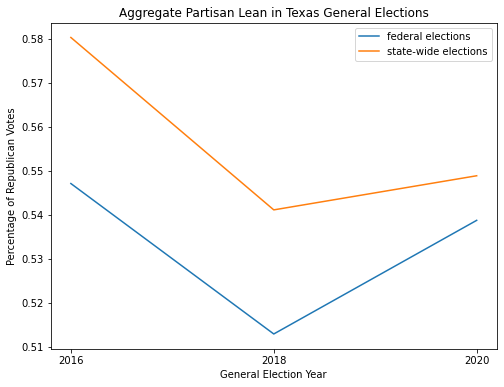

In [20]:
df3 = pd.DataFrame({
   'federal elections': fed,
   'state-wide elections': sta,
   }, index=[2016, 2018, 2020,])
lines = df3.plot.line(title = 'Aggregate Partisan Lean in Texas General Elections',
                     figsize = (8,6),
                     xticks = (2016, 2018, 2020),
                     xlabel = 'General Election Year',
                     ylabel = 'Percentage of Republican Votes')

#saving plot in figure folder
plt.savefig('./figures/agg_partisan_lean_in_ge.png')


### Investigating Downballot Dropoff

In [21]:
#initializing df
dbdo = vs_agg.loc[vs_agg.r_type != 3,['year','total_vote','race','r_type']]

In [22]:
#adding a votes-per-race average in millions
dbdo['avg_vpr_m'] = dbdo['total_vote']/(dbdo['race'] * 1000000)

#saving the df
dbdo.to_csv(r'data/cleaned/downballotdropoff.csv', index = False)

In [23]:
#checking the data frame
dbdo.head()

,year,total_vote,race,r_type,avg_vpr_m
16_2.0,16,16572183,2,2.0,8.286091
18_2.0,18,64698932,8,2.0,8.087366
20_2.0,20,32623682,3,2.0,10.874561
16_0.0,16,8010185,1,0.0,8.010185
16_1.0,16,8561998,1,1.0,8.561998


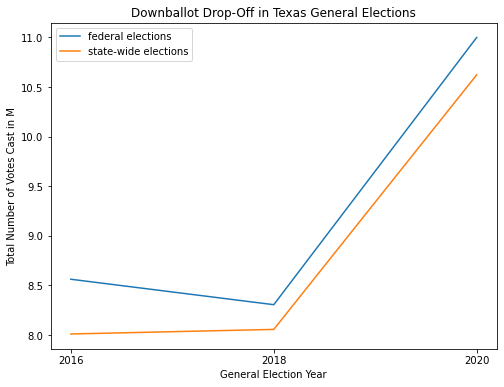

In [24]:
#Building a graph to compare average votes in millions in statewide vs federal elections

fed1 = np.array([dbdo.loc['16_1.0','avg_vpr_m'], dbdo.loc['18_1.0','avg_vpr_m'], dbdo.loc['20_1.0','avg_vpr_m']])
sta1 = np.array([dbdo.loc['16_0.0','avg_vpr_m'], dbdo.loc['18_0.0','avg_vpr_m'], dbdo.loc['20_0.0','avg_vpr_m']])

df4 = pd.DataFrame({
   'federal elections': fed1,
   'state-wide elections': sta1,
   }, index=[2016, 2018, 2020,])
lines = df4.plot.line(title = 'Downballot Drop-Off in Texas General Elections',
                      figsize = (8,6),
                      xticks = (2016, 2018, 2020),
                      xlabel = 'General Election Year',
                      ylabel = 'Total Number of Votes Cast in M')

plt.savefig('./figures/downballot_dropoff.png')

<p><a name="pvi"></a></p>

# Calculating PVI 

To calculate the PVI of each 2022 Senate District and House district, we will need to:
- sum precinct vote tallies for each election, in each year, by new senate and house districts
- calculate the republican vote percentage for all races in a given district in a year
- compare the republican vote percentage in each district to the state-wide baseline for that year
- combine the yearly pvis to an average to get the final PVI

In [25]:
#aggregating precinct vote tallies by Senate District and House District
#TODO - automate
SD_2020 = ctx_2020.groupby('SD').sum()
HD_2020 = ctx_2020.groupby('HD').sum()

SD_2018 = ctx_2018.groupby('SD').sum()
HD_2018 = ctx_2018.groupby('HD').sum()

SD_2016 = ctx_2016.groupby('SD').sum()
HD_2016 = ctx_2016.groupby('HD').sum()

In [26]:
# Matching elections to the appropriate state legislative dataset
cols_2020 = []
cols_2018 = []
cols_2016 = []

for i, item in enumerate(elec_list):
    if '16' in item:
        cols_2016.append(item)
    elif '18' in item:
        cols_2018.append(item)
    else:
        cols_2020.append(item)

In [27]:
#finding republican vote percentages per legislative chamber and election, using helper function
SD_2020, HD_2020 = find_rpct(ctx_2020, cols_2020)
SD_2018, HD_2018 = find_rpct(ctx_2018, cols_2018)
SD_2016, HD_2016 = find_rpct(ctx_2016, cols_2016)

done
done
done


In [28]:
#checking the new data frames to make sure function worked appropriately
HD_2018.head()

,uss_18_rpct,gov_18_rpct,ltg_18_rpct,atg_18_rpct,com_18_rpct,lan_18_rpct,agr_18_rpct,rrc_18_rpct
HD,,,,,,,,
1.0,0.748000,0.769617,0.718512,0.739857,0.760027,0.760044,0.746194,0.758115
2.0,0.787168,0.820732,0.775423,0.778969,0.814173,0.816148,0.794948,0.812172
3.0,0.773063,0.810117,0.781729,0.778587,0.804976,0.800189,0.782713,0.803209
4.0,0.706360,0.747295,0.707337,0.703897,0.734379,0.738968,0.717233,0.731528
5.0,0.796532,0.816910,0.772668,0.791719,0.811144,0.807095,0.797576,0.807843


In [29]:
#finding a mean republican vote percentage across each year, with helper function, and slimming the df

SD_2020 = compress_rpct(SD_2020)
SD_2018 = compress_rpct(SD_2018)
SD_2016 = compress_rpct(SD_2016)
HD_2020 = compress_rpct(HD_2020)
HD_2018 = compress_rpct(HD_2018)
HD_2016 = compress_rpct(HD_2016)

alr20 done
alr18 done
alr16 done
alr20 done
alr18 done
alr16 done


In [30]:
#Checking to make sure function worked
SD_2020.head()

,alr20
SD,
1.0,0.754471
2.0,0.592518
3.0,0.743527
4.0,0.669076
5.0,0.608653


In [31]:
#concatenating compressed dfs
sd = pd.concat([SD_2020, SD_2018, SD_2016], axis=1)
hd = pd.concat([HD_2020, HD_2018, HD_2016], axis=1)

In [32]:
hd.head()

,alr20,alr18,alr16
HD,,,
1.0,0.756535,0.750046,0.756623
2.0,0.811966,0.799967,0.819035
3.0,0.778457,0.791823,0.818583
4.0,0.706257,0.723375,0.754007
5.0,0.811315,0.800186,0.807637


In [33]:
#extracting 'baseline' values from previously aggregated dataframe
vs_agg
baseline_2020 = vs_agg.loc['20_2.0', 'r_pct'] #54.21
baseline_2018 = vs_agg.loc['18_2.0', 'r_pct'] #53.75
baseline_2016 = vs_agg.loc['16_2.0', 'r_pct'] #56.32
print(baseline_2020, baseline_2018, baseline_2016)

0.5420688566054561 0.5375255653369981 0.5631821709909913


In [34]:
hd.head()

,alr20,alr18,alr16
HD,,,
1.0,0.756535,0.750046,0.756623
2.0,0.811966,0.799967,0.819035
3.0,0.778457,0.791823,0.818583
4.0,0.706257,0.723375,0.754007
5.0,0.811315,0.800186,0.807637


In [35]:
#creating a new column in hd and sd that shows pvi per year
hd['alr20_pvi'] = hd['alr20'] - baseline_2020
hd['alr18_pvi'] = hd['alr18'] - baseline_2018
hd['alr16_pvi'] = hd['alr16'] - baseline_2016

sd['alr20_pvi'] = sd['alr20'] - baseline_2020
sd['alr18_pvi'] = sd['alr18'] - baseline_2018
sd['alr16_pvi'] = sd['alr16'] - baseline_2016

In [36]:
#creating column for average pvi
sd['pvi'] = 100* (sd['alr20_pvi'] + sd['alr18_pvi'] + sd['alr16_pvi'])/3
hd['pvi'] = 100 *(hd['alr20_pvi'] + hd['alr18_pvi'] + hd['alr16_pvi'])/3

In [37]:
#checking the dfs
sd.head()

,alr20,alr18,alr16,alr20_pvi,alr18_pvi,alr16_pvi,pvi
SD,,,,,,,
1.0,0.754471,0.749057,0.759886,0.212402,0.211532,0.196704,20.687916
2.0,0.592518,0.599823,0.640150,0.050449,0.062297,0.076968,6.323817
3.0,0.743527,0.731272,0.733660,0.201459,0.193747,0.170478,18.856115
4.0,0.669076,0.679684,0.705405,0.127007,0.142158,0.142223,13.712934
5.0,0.608653,0.615253,0.656676,0.066585,0.077728,0.093493,7.926852


In [38]:
#adding bins to interpret PVI
hd['bins'] = np.nan
sd['bins'] = np.nan

In [39]:
#using helper function to add bins to SD
test = []
for index, row in sd.iterrows():
        pct = row['pvi']
        prox = to_bin(pct) #helper function
        test.append(prox)
sd['bins'] = test
sd.head()

,alr20,alr18,alr16,alr20_pvi,alr18_pvi,alr16_pvi,pvi,bins
SD,,,,,,,,
1.0,0.754471,0.749057,0.759886,0.212402,0.211532,0.196704,20.687916,Solid R
2.0,0.592518,0.599823,0.640150,0.050449,0.062297,0.076968,6.323817,Likely R
3.0,0.743527,0.731272,0.733660,0.201459,0.193747,0.170478,18.856115,Likely R
4.0,0.669076,0.679684,0.705405,0.127007,0.142158,0.142223,13.712934,Likely R
5.0,0.608653,0.615253,0.656676,0.066585,0.077728,0.093493,7.926852,Likely R


In [40]:
#using helper function to add bins to HD
er = []
for index, row in hd.iterrows():
        pct = row['pvi']
        prox = to_bin(pct) #helper function
        er.append(prox)
hd['bins'] = er
hd.head()

,alr20,alr18,alr16,alr20_pvi,alr18_pvi,alr16_pvi,pvi,bins
HD,,,,,,,,
1.0,0.756535,0.750046,0.756623,0.214466,0.212520,0.193441,20.680901,Solid R
2.0,0.811966,0.799967,0.819035,0.269897,0.262441,0.255853,26.273033,Solid R
3.0,0.778457,0.791823,0.818583,0.236388,0.254297,0.255401,24.869551,Solid R
4.0,0.706257,0.723375,0.754007,0.164189,0.185849,0.190825,18.028753,Likely R
5.0,0.811315,0.800186,0.807637,0.269246,0.262660,0.244454,25.878696,Solid R


In [41]:
#testing to see if binning worked
sd.bins.value_counts()

Likely R    16
Likely D     7
Solid D      5
Solid R      3
Name: bins, dtype: int64

In [42]:
hd.bins.value_counts()

Likely R       43
Solid D        39
Solid R        25
Likely D       25
Competitive    18
Name: bins, dtype: int64

### Adding calculated PVI Metrics to Shapefiles to visualize

In [43]:
#trimming the dfs
sd_trim = sd[['pvi', 'bins']]
#sd_trim.head()

hd_trim = hd[['pvi', 'bins']]
#hd_trim.head()

In [44]:
#merging trimmed df to shapefile
new_senate = pd.merge(new_senate, sd_trim, left_on = 'district', right_on = 'SD')
new_senate.head()

,district,geometry,pvi,bins
0,1,"POLYGON ((-10573656.007 3743131.537, -10573658...",20.687916,Solid R
1,2,"POLYGON ((-10741964.954 3736587.161, -10741969...",6.323817,Likely R
2,3,"POLYGON ((-10573287.762 3488683.259, -10573288...",18.856115,Likely R
3,4,"POLYGON ((-10549024.009 3419251.872, -10551095...",13.712934,Likely R
4,5,"POLYGON ((-10833147.863 3476141.083, -10833400...",7.926852,Likely R


In [45]:
new_house.head()

,district,geometry
0,1,"POLYGON ((-10542597.312 3879275.569, -10542599..."
1,2,"POLYGON ((-10695048.910 3810327.976, -10695060..."
2,3,"POLYGON ((-10604704.015 3507730.286, -10604707..."
3,4,"POLYGON ((-10698470.871 3773200.168, -10698505..."
4,5,"POLYGON ((-10574656.212 3797494.056, -10574656..."


In [46]:
hd_trim.head()

,pvi,bins
HD,,
1.0,20.680901,Solid R
2.0,26.273033,Solid R
3.0,24.869551,Solid R
4.0,18.028753,Likely R
5.0,25.878696,Solid R


In [47]:
#merging trimmed df to shapefile
new_house = pd.merge(new_house, hd_trim, left_on = 'district', right_on = 'HD')
new_house.head()

,district,geometry,pvi,bins
0,1,"POLYGON ((-10542597.312 3879275.569, -10542599...",20.680901,Solid R
1,2,"POLYGON ((-10695048.910 3810327.976, -10695060...",26.273033,Solid R
2,3,"POLYGON ((-10604704.015 3507730.286, -10604707...",24.869551,Solid R
3,4,"POLYGON ((-10698470.871 3773200.168, -10698505...",18.028753,Likely R
4,5,"POLYGON ((-10574656.212 3797494.056, -10574656...",25.878696,Solid R


In [48]:
#writing finalized shapefiles to csv
new_house.to_csv(r'data/cleaned/final_house.csv', index = False)
new_senate.to_csv(r'data/cleaned/final_senate.csv', index = False)

<p><a name="vpvi"></a></p>

# Visualizing PVI

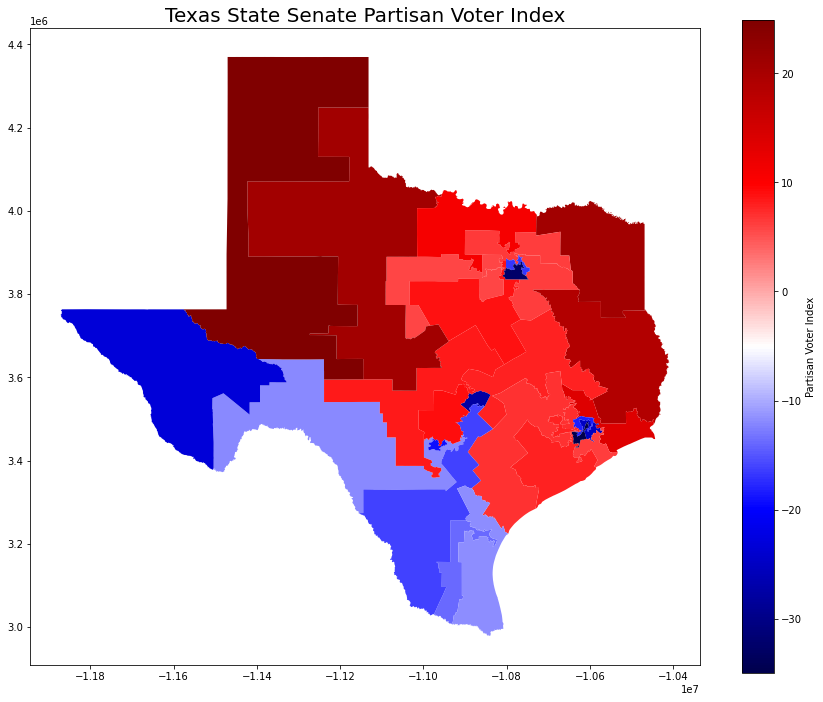

In [49]:
#mapping pvi
new_senate
new_senate.plot(column = 'pvi',
                figsize=(15, 12),
                cmap='seismic',
                legend = True,
                legend_kwds={'label': "Partisan Voter Index",
                        'orientation': "vertical"})
plt.title('Texas State Senate Partisan Voter Index', size = 20)
plt.savefig('./figures/tx_senate_pvi.png')

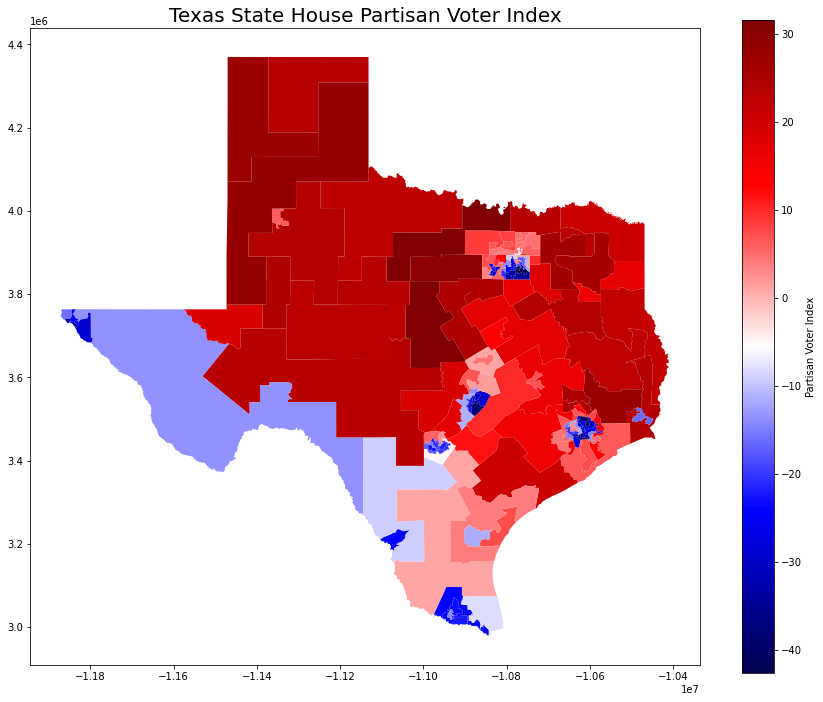

In [50]:
#mapping pvi
new_house
new_house.plot(column = 'pvi',
                figsize=(15, 12),
                cmap='seismic',
                legend = True,
                legend_kwds={'label': "Partisan Voter Index",
                        'orientation': "vertical"})
plt.title('Texas State House Partisan Voter Index', size = 20)
plt.savefig('./figures/tx_house_pvi.png')

In [51]:
sd_trim['bins'].value_counts()

Likely R    16
Likely D     7
Solid D      5
Solid R      3
Name: bins, dtype: int64

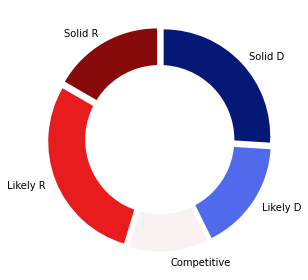

<Figure size 432x288 with 0 Axes>

In [52]:
# Pie chart for HD
labels = ['Solid R', 'Likely R', 'Competitive', 'Likely D', 'Solid D']
count = [25, 43, 18, 25, 39] #HD
#labels_2 = ['Solid R', 'Likely R', 'Competitive', 'Likely D', 'Solid D']
#count_2 = [3,16,0,7,5] #SD
#colors
colors = ['#870b0b','#e81c1c','#faf2f2', '#506aeb', '#051875']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.05)
 
plt.pie(count, colors = colors, labels=labels, startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
plt.savefig('./figures/donut_house.png')

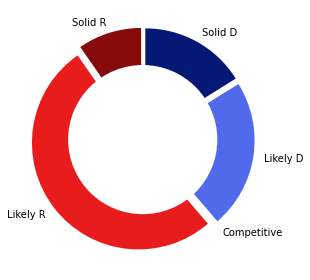

<Figure size 432x288 with 0 Axes>

In [53]:
# Pie chart for SD
#labels = ['Solid R', 'Likely R', 'Competitive', 'Likely D', 'Solid D']
#count = [25, 43, 18, 25, 39] #HD
labels_2 = ['Solid R', 'Likely R', 'Competitive', 'Likely D', 'Solid D']
count_2 = [3,16,0,7,5] #SD
#colors
colors = ['#870b0b','#e81c1c','#faf2f2', '#506aeb', '#051875']
#explsion
explode = (0.05,0.05,0.05,0.05, 0.05)
 
plt.pie(count_2, colors = colors, labels=labels_2, startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
plt.savefig('./figures/donut_senate.png')

In [65]:
new_house['comp'] = np.nan
for index, row in new_house.iterrows():
        comp = row['bins']
        if comp == 'Competitive':
            print('yes')
            new_house['comp'] = 1
        else:
            new_house['comp'] = 0
new_house.comp.value_counts()

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


0    150
Name: comp, dtype: int64

TypeError: __init__() got an unexpected keyword argument 'label'

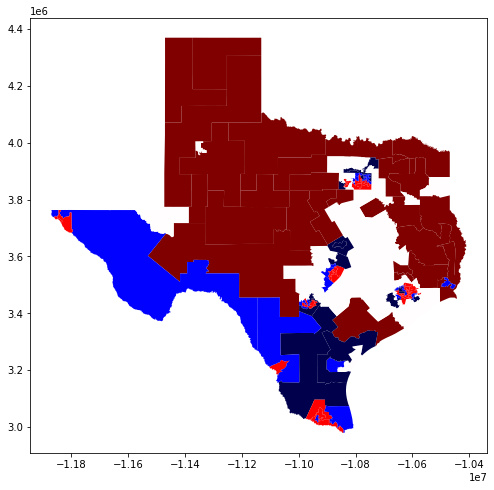

In [54]:
#mapping pvi
new_house.loc[new_house['bins'] == 'Competitive']
    df.loc[df['column_name'] == some_value]
new_house.plot(column = 'bins',
                figsize=(10, 8),
                cmap='seismic',
                legend = True,
                legend_kwds={'label': "Partisan Voter Index",
                        'orientation': "vertical"})
plt.title('Texas State House Partisan Voter Index', size = 20)
#plt.savefig('./figures/tx_house_pvi.png')

<p><a name="ta"></a></p>

# Takeaways

<p><a name="fw"></a></p>

# Future Work

Future work to improve this project's usefulness would include:

**Refining PVI Metric**

- using 2012, 2016 election return data to 'validate' PVI metric for 2020, before applying to 2022
- analyzing potential differences between using state and federal data to calculate partisan lean
      --> accounting for downballot drop off
      --> accounting for difference in partisan voting
- accounting for differences in electoral races
    --> differences in turnout for presidential election years vs midterm years
    
**Including other data sources**

- matching census 2020 demographic data to precinct returns
       --> refining precinct matching by using population weighted centroid instead of geocentroid
       --> investigating correlations between population demographics and partisan lean
- including state legislative election returns
       --> could test how well PVI metric predicts downballot elections
       --> could analyze political vulnerability by district, and turnout
- including open vs incumbent seats, campaign finance data etc
- expanding analysis to local races - mayoral, school board, county commisioners etc
    
**Expanding analysis to more states**

- could compare if some states follow national trends more in downballot races
- could apply PVI metric across states to inform issue advocacy decision making
        